In [2]:
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import cv2
    import tensorflow as tf
    import time
    import glob
    import random
    from PIL import Image
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
    from tensorflow.keras.callbacks import TensorBoard
    from tensorflow.keras.optimizers import Adam
    from keras.preprocessing import image
    import time
    import pandas as pd
    from tensorflow.keras.optimizers import Adam


    NAME = "Tcc_cnn_64_{}".format(int(time.time()))


    print(tf.config.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    if tf.test.gpu_device_name():
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    else:
        print("Please install GPU version of TF")
        

    print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Default GPU Device: /device:GPU:0
True


In [3]:
all_traning_paths = glob.glob('DATASETS/Training-Mass/*/*.jpg')
all_val_paths = glob.glob('DATASETS/Validation-Mass/*/*.jpg')

DATASETS/Training-Mass\WITHOUT CANCER\1-243 (1).jpg


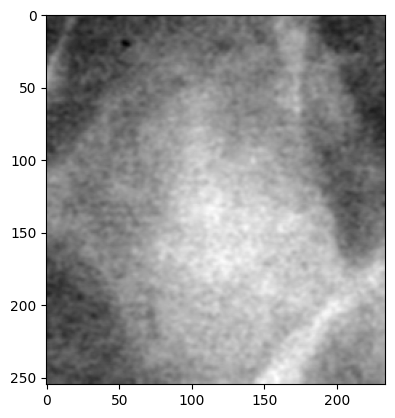

In [5]:
img_path=random.choice(all_traning_paths)
cropped_img = Image.open(img_path)

gray = cropped_img.convert('L')
median =cv2.blur(np.array(gray), (3, 3))
print(img_path)
plt.imshow(median, cmap='gray')

In [6]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen_resnet.flow_from_directory('DATASETS/Training-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16 
                            )


validation_gen = datagen_resnet.flow_from_directory('DATASETS/Validation-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16
                            )

test_gen = datagen_resnet.flow_from_directory('DATASETS/Testing-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=16,
                            )

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Found 464 images belonging to 2 classes.


In [7]:
base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

for layer in base_model.layers:  # ´Passo para eu não retreinar as camadas do RESNET
    layer.trainable=False
    
    tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

# Modelo inicial


In [8]:
modelo = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo.summary() ## me 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
______________________________________

In [9]:
modelo.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history = modelo.fit(train_gen, 
           validation_data=validation_gen,
           epochs=10,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/10
60/60 [==============================] - 10s 52ms/step - loss: 0.8065 - accuracy: 0.5228 - val_loss: 0.7656 - val_accuracy: 0.5479
Epoch 2/10
60/60 [==============================] - 2s 39ms/step - loss: 0.6792 - accuracy: 0.6106 - val_loss: 0.6603 - val_accuracy: 0.6096
Epoch 3/10
60/60 [==============================] - 2s 39ms/step - loss: 0.6133 - accuracy: 0.6698 - val_loss: 0.6725 - val_accuracy: 0.5685
Epoch 4/10
60/60 [==============================] - 2s 39ms/step - loss: 0.5853 - accuracy: 0.6889 - val_loss: 0.6303 - val_accuracy: 0.6370
Epoch 5/10
60/60 [==============================] - 2s 39ms/step - loss: 0.5632 - accuracy: 0.6974 - val_loss: 0.6242 - val_accuracy: 0.6644
Epoch 6/10
60/60 [==============================] - 2s 39ms/step - loss: 0.5309 - accuracy: 0.7323 - val_loss: 0.6240 - val_accuracy: 0.6370
Epoch 7/10
60/60 [==============================] - 2s 39ms/step - loss: 0.5204 - accuracy: 0.7492 - val_loss: 0.6130 - val_accuracy: 0.6644
Epoch 8/10
6

<Axes: >

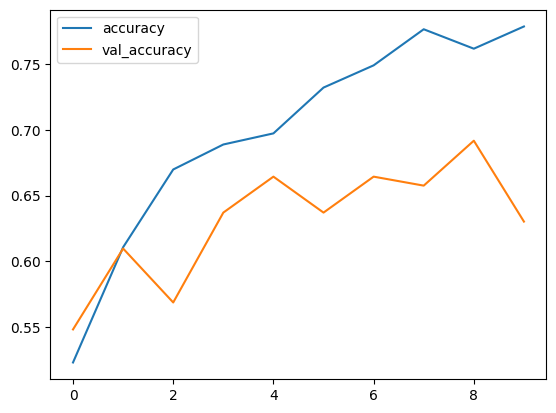

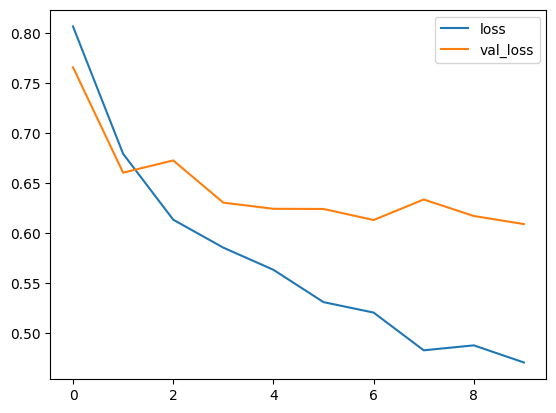

In [10]:

df = pd.DataFrame(history.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

In [11]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.806482,0.522751,0.765639,0.547945
1,0.679195,0.610582,0.660321,0.609589
2,0.613292,0.669841,0.672549,0.568493
3,0.585332,0.688889,0.630337,0.636986
4,0.563184,0.697354,0.624189,0.664384
5,0.530867,0.732275,0.624006,0.636986
6,0.520414,0.749206,0.612959,0.664384
7,0.482694,0.776720,0.633487,0.657534
8,0.487629,0.761905,0.616969,0.691781
9,0.470520,0.778836,0.608905,0.630137


# 2 AUMENTANDO CAMADAS

In [12]:
modelo2 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
____________________________________

In [13]:
modelo2.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )
history = modelo2.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 5s 52ms/step - loss: 0.7499 - accuracy: 0.5577 - val_loss: 0.6709 - val_accuracy: 0.5890
Epoch 2/15
60/60 [==============================] - 2s 39ms/step - loss: 0.6603 - accuracy: 0.6201 - val_loss: 0.6377 - val_accuracy: 0.6370
Epoch 3/15
60/60 [==============================] - 2s 39ms/step - loss: 0.6111 - accuracy: 0.6561 - val_loss: 0.6102 - val_accuracy: 0.7192
Epoch 4/15
60/60 [==============================] - 2s 40ms/step - loss: 0.5826 - accuracy: 0.6984 - val_loss: 0.6185 - val_accuracy: 0.6575
Epoch 5/15
60/60 [==============================] - 2s 39ms/step - loss: 0.5425 - accuracy: 0.7143 - val_loss: 0.6104 - val_accuracy: 0.6712
Epoch 6/15
60/60 [==============================] - 2s 40ms/step - loss: 0.5393 - accuracy: 0.7333 - val_loss: 0.6143 - val_accuracy: 0.6507
Epoch 7/15
60/60 [==============================] - 2s 39ms/step - loss: 0.5187 - accuracy: 0.7460 - val_loss: 0.6089 - val_accuracy: 0.6644
Epoch 8/15
60

In [14]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.749901,0.557672,0.670876,0.589041
1,0.660317,0.620106,0.637749,0.636986
2,0.611074,0.656085,0.610235,0.719178
3,0.582648,0.698413,0.618461,0.657534
4,0.542487,0.714286,0.610364,0.671233
5,0.539311,0.733333,0.614294,0.650685
6,0.518660,0.746032,0.608871,0.664384
7,0.502188,0.759788,0.604977,0.678082
8,0.482174,0.764021,0.606516,0.671233
9,0.469689,0.762963,0.602041,0.691781


<Axes: >

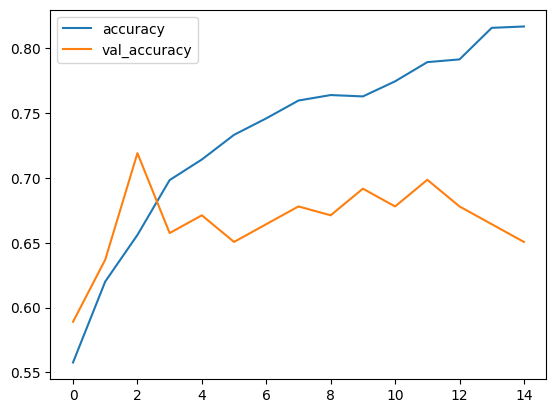

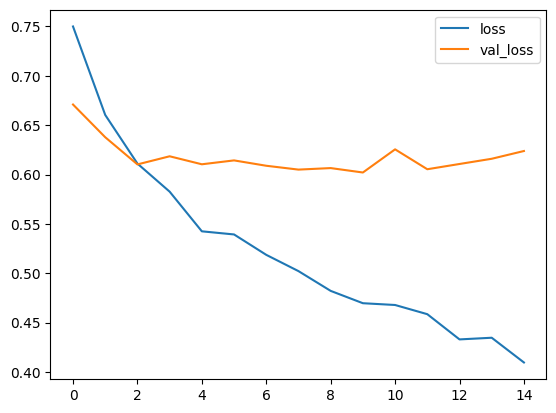

In [15]:
df = pd.DataFrame(history.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Modelo 3 ADICIONANDO MAIS UMA CADMADA DENSE E UMA DE DROPOUT

In [16]:
modelo3 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

modelo3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [17]:
modelo3.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history3 = modelo3.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 5s 51ms/step - loss: 0.8403 - accuracy: 0.5460 - val_loss: 0.6737 - val_accuracy: 0.6096
Epoch 2/15
60/60 [==============================] - 2s 40ms/step - loss: 0.6911 - accuracy: 0.5894 - val_loss: 0.6579 - val_accuracy: 0.6027
Epoch 3/15
60/60 [==============================] - 2s 41ms/step - loss: 0.6346 - accuracy: 0.6413 - val_loss: 0.6339 - val_accuracy: 0.6370
Epoch 4/15
60/60 [==============================] - 2s 40ms/step - loss: 0.6163 - accuracy: 0.6593 - val_loss: 0.6294 - val_accuracy: 0.6507
Epoch 5/15
60/60 [==============================] - 2s 40ms/step - loss: 0.5875 - accuracy: 0.6878 - val_loss: 0.6416 - val_accuracy: 0.6096
Epoch 6/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5595 - accuracy: 0.7196 - val_loss: 0.6159 - val_accuracy: 0.6507
Epoch 7/15
60/60 [==============================] - 3s 43ms/step - loss: 0.5443 - accuracy: 0.7185 - val_loss: 0.6122 - val_accuracy: 0.6849
Epoch 8/15
60

<Axes: >

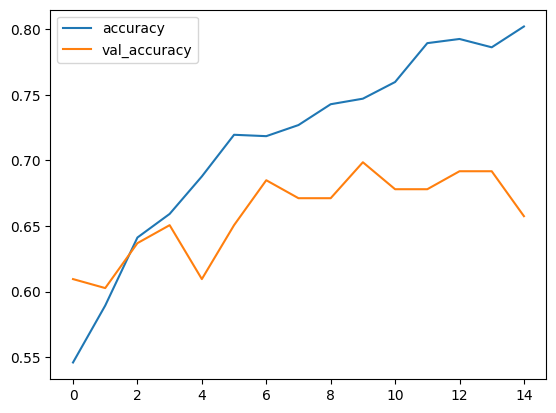

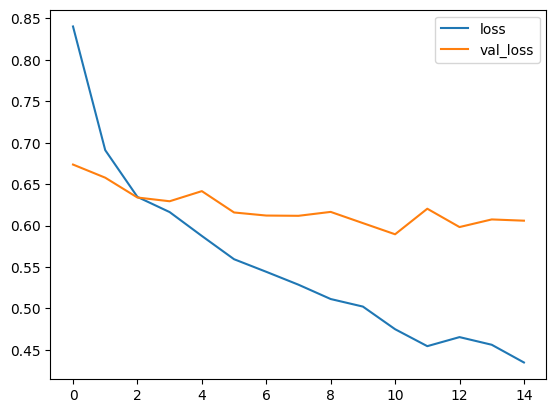

In [18]:
df = pd.DataFrame(history3.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

In [19]:
pd.DataFrame(history3.history)

,loss,accuracy,val_loss,val_accuracy
0,0.840326,0.546032,0.673706,0.609589
1,0.691080,0.589418,0.657854,0.602740
2,0.634631,0.641270,0.633909,0.636986
3,0.616338,0.659259,0.629413,0.650685
4,0.587548,0.687831,0.641631,0.609589
5,0.559461,0.719577,0.615873,0.650685
6,0.544275,0.718518,0.612162,0.684932
7,0.528705,0.726984,0.611851,0.671233
8,0.511423,0.742857,0.616568,0.671233
9,0.502314,0.747090,0.603044,0.698630


# Adicionando ao modelo 3 mais uma dense e de dropout 

In [20]:
modelo4 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.4),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(32, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])



In [21]:
modelo4.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history3 = modelo4.fit(train_gen, 
           validation_data=validation_gen,
           epochs=15,
           batch_size=16,
           callbacks=[tensorBoard]
        )

Epoch 1/15
60/60 [==============================] - 6s 55ms/step - loss: 0.8060 - accuracy: 0.5005 - val_loss: 0.6998 - val_accuracy: 0.5068
Epoch 2/15
60/60 [==============================] - 3s 41ms/step - loss: 0.7068 - accuracy: 0.5534 - val_loss: 0.6942 - val_accuracy: 0.5342
Epoch 3/15
60/60 [==============================] - 2s 41ms/step - loss: 0.7093 - accuracy: 0.5471 - val_loss: 0.6821 - val_accuracy: 0.5548
Epoch 4/15
60/60 [==============================] - 2s 41ms/step - loss: 0.6939 - accuracy: 0.5524 - val_loss: 0.6782 - val_accuracy: 0.5753
Epoch 5/15
60/60 [==============================] - 2s 41ms/step - loss: 0.6836 - accuracy: 0.5725 - val_loss: 0.6782 - val_accuracy: 0.5685
Epoch 6/15
60/60 [==============================] - 3s 42ms/step - loss: 0.6662 - accuracy: 0.6011 - val_loss: 0.6737 - val_accuracy: 0.6096
Epoch 7/15
60/60 [==============================] - 2s 41ms/step - loss: 0.6438 - accuracy: 0.6328 - val_loss: 0.6697 - val_accuracy: 0.5890
Epoch 8/15
60

<Axes: >

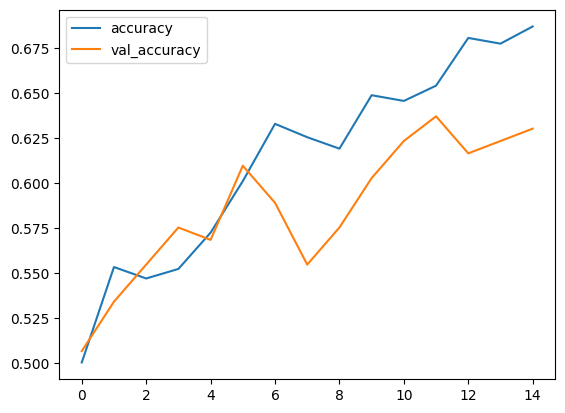

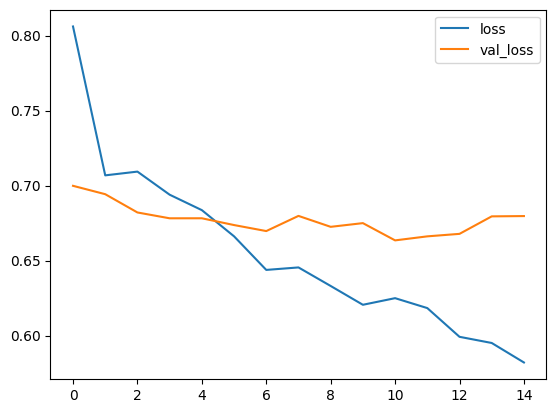

In [22]:
df = pd.DataFrame(history3.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# Aumentando bach size usando modelo 3

In [23]:
atagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Training-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32 
                            )


validation_gen_32 = datagen_resnet.flow_from_directory('DATASETS/Validation-Mass/',
                            target_size=(224,224),
                            class_mode="categorical",
                            batch_size=32
                            )

Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [24]:
modelo_op = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

In [25]:
modelo_op.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history_op = modelo_op.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=15,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/15
30/30 [==============================] - 5s 100ms/step - loss: 0.7770 - accuracy: 0.5291 - val_loss: 0.6806 - val_accuracy: 0.5548
Epoch 2/15
30/30 [==============================] - 2s 73ms/step - loss: 0.6956 - accuracy: 0.5820 - val_loss: 0.6624 - val_accuracy: 0.5616
Epoch 3/15
30/30 [==============================] - 2s 73ms/step - loss: 0.6508 - accuracy: 0.6127 - val_loss: 0.6406 - val_accuracy: 0.6233
Epoch 4/15
30/30 [==============================] - 2s 72ms/step - loss: 0.6306 - accuracy: 0.6540 - val_loss: 0.6374 - val_accuracy: 0.6233
Epoch 5/15
30/30 [==============================] - 2s 72ms/step - loss: 0.6212 - accuracy: 0.6688 - val_loss: 0.6294 - val_accuracy: 0.6301
Epoch 6/15
30/30 [==============================] - 2s 72ms/step - loss: 0.5903 - accuracy: 0.6815 - val_loss: 0.6261 - val_accuracy: 0.6918
Epoch 7/15
30/30 [==============================] - 2s 72ms/step - loss: 0.5809 - accuracy: 0.7101 - val_loss: 0.6160 - val_accuracy: 0.6575
Epoch 8/15
3

<Axes: >

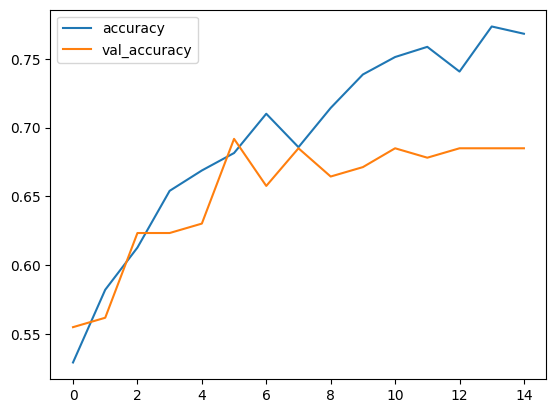

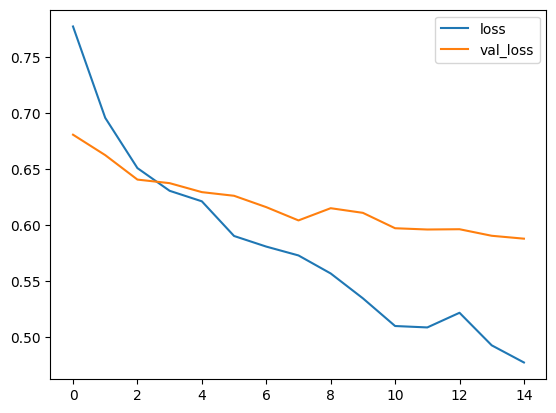

In [26]:
df = pd.DataFrame(history_op.history)

df[['accuracy', 'val_accuracy']].plot()
df[['loss', 'val_loss']].plot()

# reduzindo epocas do modelo op de 15 para 9


In [27]:
modelo_nove = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(128, activation='relu'),
                     Dropout(0.2),
                     Dense(64, activation='relu'),
                     Dropout(0.2),
                     Dense(2, activation='Softmax')
])

In [28]:
modelo_nove.compile(optimizer=Adam(learning_rate=1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

history_nove = modelo_nove.fit(train_gen_32, 
           validation_data=validation_gen_32,
           epochs=9,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/9
30/30 [==============================] - 6s 99ms/step - loss: 0.8018 - accuracy: 0.5164 - val_loss: 0.6841 - val_accuracy: 0.5616
Epoch 2/9
30/30 [==============================] - 2s 73ms/step - loss: 0.6985 - accuracy: 0.6000 - val_loss: 0.6485 - val_accuracy: 0.5959
Epoch 3/9
30/30 [==============================] - 2s 73ms/step - loss: 0.6357 - accuracy: 0.6286 - val_loss: 0.6356 - val_accuracy: 0.6096
Epoch 4/9
30/30 [==============================] - 2s 71ms/step - loss: 0.6147 - accuracy: 0.6455 - val_loss: 0.6354 - val_accuracy: 0.5753
Epoch 5/9
30/30 [==============================] - 2s 72ms/step - loss: 0.5942 - accuracy: 0.6751 - val_loss: 0.6157 - val_accuracy: 0.6438
Epoch 6/9
30/30 [==============================] - 2s 72ms/step - loss: 0.5910 - accuracy: 0.6847 - val_loss: 0.6254 - val_accuracy: 0.6164
Epoch 7/9
30/30 [==============================] - 2s 72ms/step - loss: 0.5561 - accuracy: 0.7259 - val_loss: 0.6046 - val_accuracy: 0.6507
Epoch 8/9
30/30 [===

<Axes: >

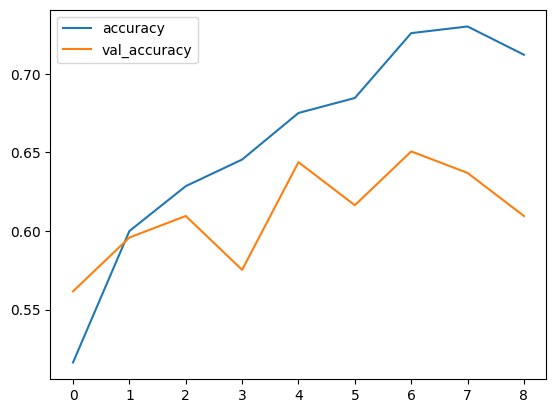

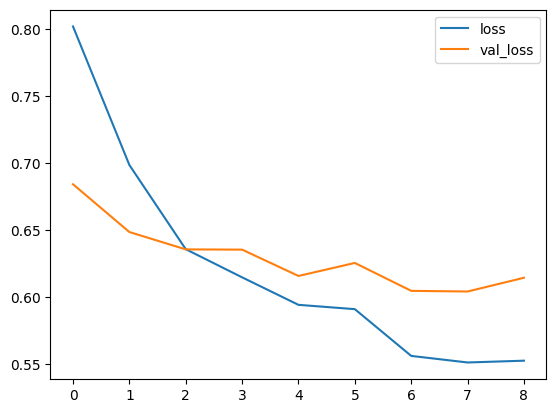

In [29]:
pd2 = pd.DataFrame(history_nove.history)

pd2[['accuracy', 'val_accuracy']].plot()
pd2[['loss', 'val_loss']].plot()

In [30]:
predictions = modelo4.predict(test_gen, verbose=1)

29/29 [==============================] - 2s 37ms/step


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
classes_name = ('cancer', 'sem cancer')
height, width = (224, 224)


test_set = test_gen
test_set.reset()
y_pred = np.argmax(predictions, axis=-1)

y_test = test_gen.labels
cm = confusion_matrix(y_test,y_pred)

print(cm)

cm2 = classification_report(test_gen.classes, y_pred)

print(classification_report(test_gen.classes, y_pred))


file = open('time_bin_metrics.txt', 'w')
file.write('tempo %s' % cm2)
file.close()

[[129 105]
 [129 101]]
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       234
           1       0.49      0.44      0.46       230

    accuracy                           0.50       464
   macro avg       0.50      0.50      0.49       464
weighted avg       0.50      0.50      0.49       464



[[129 105]
 [129 101]]


<Axes: >

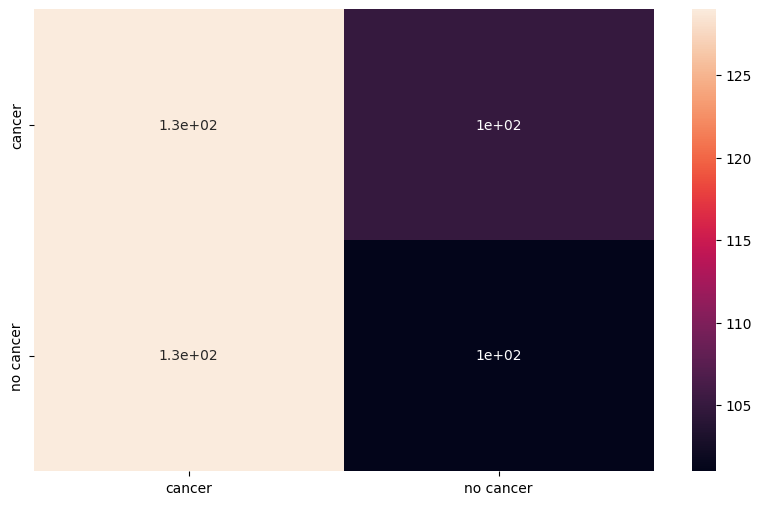

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(cm)
index = ['cancer','no cancer']  
columns = ['cancer','no cancer']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [33]:
import numpy as np

In [34]:
def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo2.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in train_gen.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)

1/1 [==============================] - 1s 629ms/step


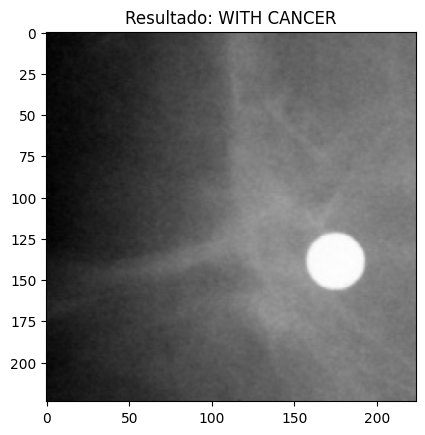

In [35]:
predicao(modelo,'DATASETS/Validation-Mass/WITH CANCER/2-233.jpg')